## 6.1 파이프라인을 사용한 효율적인 워크플로

In [3]:
# 위스콘신 유방암 데이터셋 로드

import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', 
                 header=None)

In [31]:
# feature와 target 데이터로 분류 & LabelEncoder로 범주형 데이터를 수치형 데이터로 인코딩

from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [32]:
le.transform(['M', 'B'])

array([1, 0])

In [33]:
# 학습 데이터와 테스트 데이터로 split

from sklearn.model_selection import train_test_split

"""
- stratify 값으로는 target 값을 지정
- stratify값을 target 값으로 지정해주면 target의 class 비율을 유지 한 채로 데이터 셋을 split

- random_state 파라미터는 train_test_split 함수를 호출할 때마다 동일한 학습/테스트 데이터셋을 생성하기 위한 난수값
"""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

#### Explanation)

- 표준화, 주성분 분석, 로지스틱 회귀를 포함하는 pipeline 객체 생성

- make_pipeline 함수는 여러 개의 사이킷런 변환기(입력에 대해 fit 메서드와 transform 메서드를 지원하는 객체)와 그 뒤에 fit 메서드와predict 메서드를 구현한 사이킷런 사이킷런 추정기를 연결할 수 있다.

- Pipeline 객체의 fit 메서드를 호출하면 데이터가 중간 단계에 있는 모든 변환기의 fit 메서드와 transform 메서드를 차례로 거쳐 추정기 객체(파이프라인의 마지막 단계)에 도달한다.
- 추정기는 변환된 훈련 데이터셋을 사용하여 학습
- 파이프라인의 중간 단계의 횟수는 제한이 없다.

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(), 
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))

테스트 정확도: 0.956


In [39]:
# 추정기 객체를 주피터 노트북에서 시각화

from sklearn import set_config

set_config(display='diagram')
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])

## 6.2 k-겹 교차 검증을 사용한 모델 성능 평가

### 6.2.1 홀드아웃 방법

- 홀드아웃 방법: 초기 데이터셋을 훈련 데이터셋과 테스트 데이터셋으로 나누는 것
- 모델 선택 (model selection): 최적의 파라미터 혹은 하이퍼파라미터를 선택하는 것

홀드아웃 교차 검증
- 초기 데이터를 훈련 데이터, 검증 데이터, 테스트 데이터의 세 개 부분으로 나눈다.
- 검증 데이터셋을 사용하여 반복적으로 다른 하이퍼파라미터 값에서 모델을 훈련한 후 성능을 평가하는 방식으로 최적의 하이퍼파라미터 값을 찾는다.

### 6.2.2 k-겹 교차 검증

- 중복을 허용하지 않고 훈련 데이터셋을 k개의 fold로 랜덤하게 나눈다.
- (k - 1)개의 fold로 모델을 훈련하고 나머지 하나의 fold로 성능을 평가한다.
- 이런 과정을 k번 반복하여 k개의 모델과 성능 추정을 얻는다. 
- 그다음 서로 다른 독립적인 fold에서 얻은 성능 추정을 기반으로 모델의 평균 성능을 계산한다.
- 만족스러운 하이퍼파라미터 값을 찾은 후에는 전체 훈련 데이터셋을 사용하여 모델을 다시 훈련한다.
- 그다음 독립적인 테스트 데이터셋을 사용하여 최종 성능 추정을 한다.

- k-겹 교차 검증은 중복을 허용하지 않는 리샘플링 기법 - 샘플이 독립적이고 공분산이 0이다.
- k-겹 교차 검증 방식은 홀드아웃 방식에 비해 훈련 데이터셋의 분할에 덜 민감한 성능 추정값을 얻을 수 있으며, 분산이 낮다.

#### Note) LOOVC 방법 (Leave-One-Out Cross-Validation)

- 폴드 개수가 훈련 샘플 개수와 같다. (k = n)
- 즉, 하나의 훈련 샘플이 각 반복에서 테스트 데이터로 사용된다. 

- 아주 작은 데이터셋을 사용할 때 권장되는 방법

In [93]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train) # 계층적 교차 검증은 각 폴드에서 클래스 비율이 전체 훈련 데이터셋에 있는 클래스 비율과 동일하도록 유지
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' % (k+1, np.bincount(y_train[train]), score))

# bincount() : 0부터 가장 큰 값까지 각각의 발생 빈도수를 계산

폴드:  1, 클래스 분포: [256 153], 정확도: 0.935
폴드:  2, 클래스 분포: [256 153], 정확도: 0.935
폴드:  3, 클래스 분포: [256 153], 정확도: 0.957
폴드:  4, 클래스 분포: [256 153], 정확도: 0.957
폴드:  5, 클래스 분포: [256 153], 정확도: 0.935
폴드:  6, 클래스 분포: [257 153], 정확도: 0.956
폴드:  7, 클래스 분포: [257 153], 정확도: 0.978
폴드:  8, 클래스 분포: [257 153], 정확도: 0.933
폴드:  9, 클래스 분포: [257 153], 정확도: 0.956
폴드: 10, 클래스 분포: [257 153], 정확도: 0.956


In [92]:
print('CV 정확도: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV 정확도: 0.950 +/- 0.014


In [97]:
# k-겹 교차 검증
"""
cross_val_score 함수가 검증에 사용하는 기본 측정 지표는 회귀일 때는 R2, 분류일 때는 정확도
"""

from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1) 

# cv : 교차 검증 폴드 수
# n_jobs : 사용할 cpu 코어 수를 지정

print('CV 정확도 점수: %s' % scores)

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


In [96]:
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도: 0.950 +/- 0.014


In [98]:
# cross_validate 함수는 scoring 하이퍼파라미터에 여러 측정 지표를 설정하여 교차 검증에 사용할 수 있다.

from sklearn.model_selection import cross_validate

scores = cross_validate(estimator=pipe_lr, X=X_train, y=y_train, scoring=['accuracy'], cv=10, n_jobs=1)
print('CV 정확도 점수: %s' % scores['test_accuracy'])

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


In [101]:
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))

CV 정확도: 0.950 +/- 0.014


In [106]:
# cross_val_predict 함수는 훈련 데이터셋의 각 샘플이 테스트 fold가 되었을 때 만들어진 예측을 반환

from sklearn.model_selection import cross_val_predict

preds = cross_val_predict(estimator=pipe_lr, X=X_train, y=y_train, cv=10)
preds

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,

## 6.3 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅

### 6.3.1 학습 곡선으로 편향과 분산 문제 분석

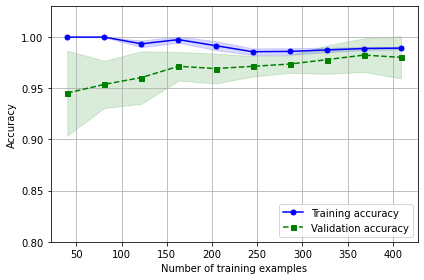

In [107]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1))

# trian_sizes : 학습 곡선을 생성하는 데 사용할 훈련 샘플의 개수나 비율을 지정할 수 있다. 
# linspace(start, stop, num) : start 와 stop 사이 범위에서 num 개수만큼 일정한 간격으로 요소 생성

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, 
                                                        X=X_train, 
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, 
         train_mean, 
         color='blue', 
         marker='o', 
         markersize=5, 
         label='Training accuracy')


# fill_between() : 그래프의 특정 영역을 색상으로 채우는 함수 -> 두 수평 방향의 곡선 사이를 채운다.
plt.fill_between(train_sizes, 
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', 
         marker='s', markersize=5, label='Validation accuracy')

plt.fill_between(train_sizes, 
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

In [118]:
(train_mean + train_std) - (train_mean - train_std)

array([0.        , 0.        , 0.00655738, 0.00601102, 0.00882353,
       0.00658143, 0.00625474, 0.00428135, 0.00292672, 0.00239559])

In [119]:
(test_mean + test_std) - (test_mean - test_std)

array([0.08294426, 0.04613706, 0.05134391, 0.02792254, 0.02908261,
       0.01997665, 0.01715486, 0.02780931, 0.03290192, 0.04126735])